In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Data loading

In [2]:


dfImages = pd.read_csv('../data/IAPS.csv',
                       sep=';',
                       usecols=['IAPS', 'ValenceMean', 'ArousalMean']
                      )



dfSounds = pd.read_csv('../data/IADS2.csv', sep=';', usecols=['Number', 'ValenceMean', 'ArousalMean'])


studyDatafiles = glob.glob('../data/procedura/*.txt')

li = []

for filename in studyDatafiles:
    df = pd.read_csv(filename, sep='\t', header=None, names=['ID', 'nn', 'Condition', 'SpecificCondition', 'Number', 'IAPS', 'Widget', 'Response', 'Delay', 'ApperanceTimestamp'])
    li.append(df)
                         
dfStudy = pd.concat(li, axis=0, ignore_index=True)

                                     


## Preprocessing

,SpecificCondition,ImageCondition,ImageValence,ImageArousal,SoundCondition,SoundValence,SoundArousal,ActualValence,ActualArousal,Label
0,p-s+,-1,1.91,5.60,1,6.47,7.32,5.337471,5.629460,1
9,p-s+,-1,1.31,6.91,1,5.68,6.82,3.167305,6.537720,-1
16,p+s-,1,7.01,6.84,-1,3.08,6.57,5.000000,5.875007,1
18,p-s+,-1,2.83,6.54,1,7.32,5.55,5.000000,5.547561,1
19,p-s+,-1,2.06,6.36,1,6.53,5.84,4.606838,5.682551,-1


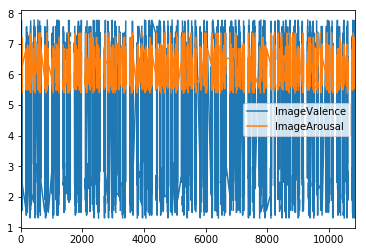

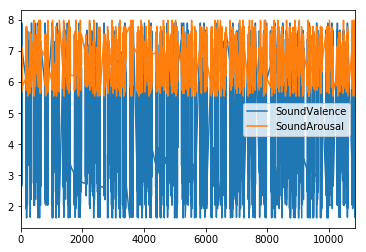

In [3]:


dfStudy = dfStudy[dfStudy.Condition != 'con']
dfStudy = dfStudy[dfStudy.Widget != 'emoscale1']
dfStudy['Number'] = pd.to_numeric(dfStudy['Number'])



def convertResponseStringIntoColumns(string):
    string = string[1:-1]
    array = (string.split(','))
    array[0] = (float(array[0]) * 4) + 5
    array[1] = (float(array[1][1:]) * 4) + 5
    return array

def findExpectedImageReaction(iaps):
    if iaps >= 4000 and iaps < 5000:
        return [np.nan, np.nan]
    valence = dfImages[dfImages.IAPS == str(iaps)].ValenceMean.tolist()
    arousal = dfImages[dfImages.IAPS == str(iaps)].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def findExpectedSoundReaction(number):
    valence = dfSounds[dfSounds.Number == number].ValenceMean.tolist()
    arousal = dfSounds[dfSounds.Number == number].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def applySpecificCondition(condition, i):
    if (condition[1] == '-' and i == 0) or (condition[3] == '-' and i == 1):
        return -1
    else:
        return 1

def labelReaction(valence):
    return -1 if valence < 5 else 1

    
def getValence(array):
    return array[0]

def getArousal(array):
    return array[1]
    
dfStudy['ActualReaction'] = dfStudy.Response.apply(func = convertResponseStringIntoColumns)

dfStudy['ExpectedImageReaction'] = dfStudy.IAPS.apply(findExpectedImageReaction)
dfStudy['ExpectedSoundReaction'] = dfStudy.Number.apply(findExpectedSoundReaction)
       
dfStudy['ImageCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 0)
dfStudy['SoundCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 1)

dfStudy['ImageValence'] = dfStudy.ExpectedImageReaction.apply(getValence)
dfStudy['ImageArousal'] = dfStudy.ExpectedImageReaction.apply(getArousal)
dfStudy['SoundValence'] = dfStudy.ExpectedSoundReaction.apply(getValence)
dfStudy['SoundArousal'] = dfStudy.ExpectedSoundReaction.apply(getArousal)
dfStudy['ActualValence'] = dfStudy.ActualReaction.apply(getValence)
dfStudy['ActualArousal'] = dfStudy.ActualReaction.apply(getArousal)
dfStudy['Label'] = dfStudy.ActualValence.apply(labelReaction)

df = dfStudy[['SpecificCondition',
              'ImageCondition',
              'ImageValence',
              'ImageArousal',
              'SoundCondition',
              'SoundValence',
              'SoundArousal',
              'ActualValence',
              'ActualArousal',
              'Label'
             ]]
df = df.dropna()

imageData =  dfStudy[['ImageValence', 'ImageArousal']]
soundData =  dfStudy[['SoundValence', 'SoundArousal']]

imageData.plot()
soundData.plot()

df.head()


## Linear Regression Model



In [4]:


x = df[['ImageCondition', 'ImageValence', 'ImageArousal',
        'SoundCondition', 'SoundValence', 'SoundArousal']]
    
y = df[['Label']]

clf = LinearRegression(n_jobs=-1)
X = np.array(x)
Y =  np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)
print('Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label')
print(clf.score(X_test, Y_test))
print(clf.coef_)

X = np.array(df[['ImageValence',
        'SoundValence']])
X = preprocessing.scale(X)
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(clf.score(X_test, Y_test))
print(clf.coef_)



X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(clf.score(X_test, Y_test))
print(clf.coef_)

      






Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label
0.14025622812721206
[[ 1.91242357e+00 -6.72765394e-01  1.25413868e-01 -1.91242357e+00
   1.00596059e+00  5.54558585e-04]]
ImageValence SoundValence || ActualValence
0.16977547811655713
[1.69404964 1.09907949]
ImageArousal SoundArousal || ActualArousal
-0.019901633813470987
[0.24285094 0.35183126]


## SVR

In [5]:


clf = svm.SVR(kernel='linear', gamma='auto')

X = np.array(df[['ImageValence',
        'SoundValence']])
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(clf.score(X_test, Y_test))
print(clf.coef_)

      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(clf.score(X_test, Y_test))
print(clf.coef_)





ImageValence SoundValence || ActualValence
0.17915501838754166
[[0.71909185 0.51318735]]
ImageArousal SoundArousal || ActualArousal
0.003348608526516972
[[0.27389133 0.366213  ]]


## OLS Regression

                            OLS Regression Results                            
Dep. Variable:          ActualValence   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     298.4
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          2.32e-115
Time:                        12:53:44   Log-Likelihood:                -4262.4
No. Observations:                2199   AIC:                             8531.
Df Residuals:                    2196   BIC:                             8548.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.5024      0.324     -4.641   

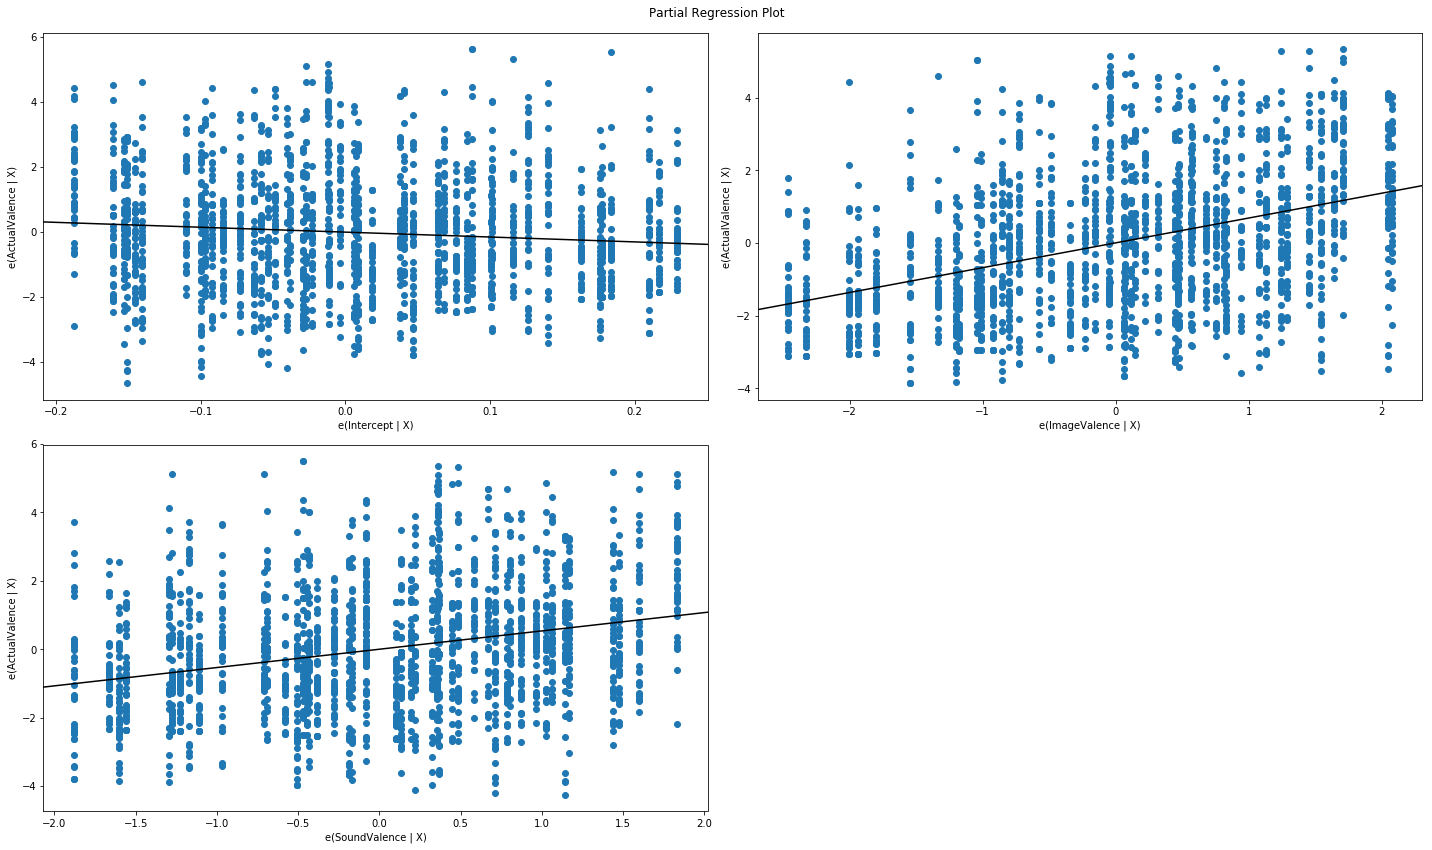

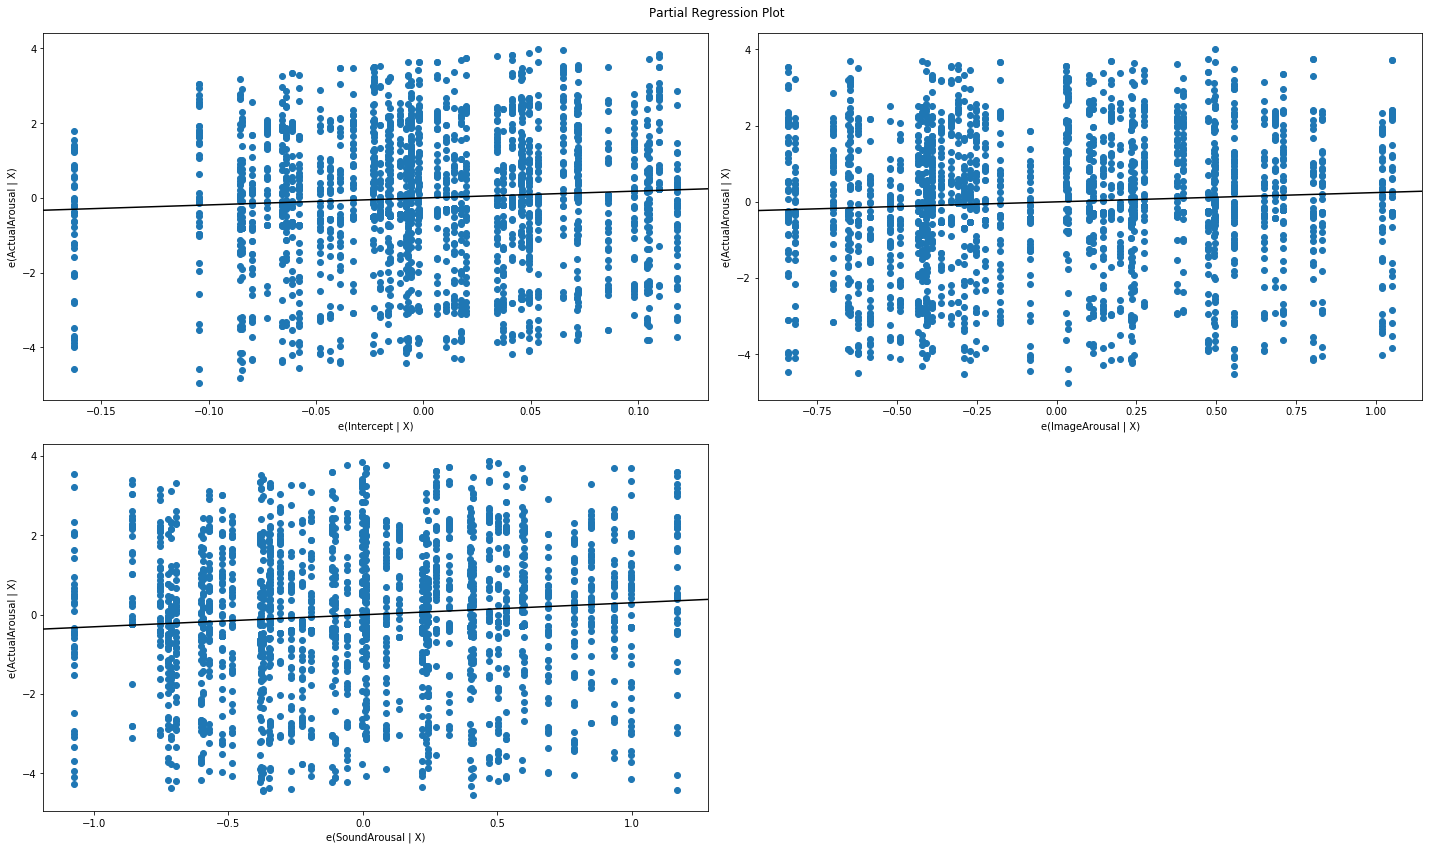

In [55]:
olsModel = ols("""ActualValence ~ ImageValence + SoundValence""", data=df).fit()

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)

print(olsModel.summary())


olsModel = ols("""ActualArousal ~ ImageArousal + SoundArousal""", data=df).fit()

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)

print(olsModel.summary())


## Decision Tree

In [124]:

# splitter - random/best | min_samples_split | min_weight_fraction_leaf
clf = DecisionTreeRegressor(max_depth=5, max_features='sqrt')

X = np.array(df[['ImageValence',
        'SoundValence']])
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(clf.score(X_test, Y_test))


      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(clf.score(X_test, Y_test))






ImageValence SoundValence || ActualValence
0.349366947299249
ImageArousal SoundArousal || ActualArousal
0.06287062295514667


In [42]:
p = df[df.ImageCondition == -1]
s = df[df.SoundCondition == -1]

pp = df[df.ImageCondition == 1]
sp = df[df.SoundCondition == 1]


pn = p[p.Label == -1]
ppp = pp[pp.Label == 1]
sn = s[s.Label == -1]
spp = sp[sp.Label == 1]

print('Picture: Negative Condition, Negative Label Percentage: ' + str(len(pn) / len(p) * 100) + ' %')

print('Picture: Positive Condition, Positve Label Percentage: ' + str(len(ppp) / len(pp) * 100) + ' %')


print('Sound: Negative Condition, Negative Label Percentage: ' + str(len(sn) / len(s) * 100) + ' %')

print('Sound: Positive Condition, Positve Label Percentage: ' + str(len(spp) / len(sp) * 100) + ' %')

Picture: Negative Condition, Negative Label Percentage: 74.364896073903 %
Picture: Positive Condition, Positve Label Percentage: 55.333333333333336 %
Sound: Negative Condition, Negative Label Percentage: 44.666666666666664 %
Sound: Positive Condition, Positve Label Percentage: 25.635103926096996 %
